In [1]:
import pickle
import pandas as pd
import numpy as np

file = open('/home/tom/work/rltensor/rltensor/app/ticker1.pkl', 'rb')
tickers = pickle.loads(file.read())
tickers = tickers[1:]
print(tickers)

closes = []
for ticker in tickers:
    df = pd.read_csv(f'../datasets/crypto/{ticker}.csv')
    closes.append(df['close'].values[:1000] / df['close'].values[0])
closes = np.stack(closes, axis=1)

['USDT_BTC', 'USDT_DASH', 'USDT_ETC', 'USDT_ETH', 'USDT_LTC', 'USDT_XMR', 'USDT_ZEC']


In [2]:
closes.shape

(1000, 7)

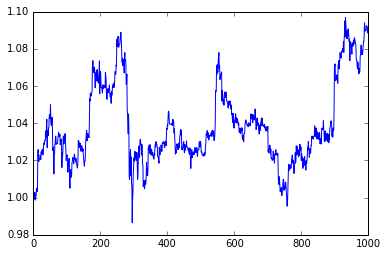

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(closes[:, 0])

In [4]:
from pykalman import KalmanFilter

In [5]:
state_dim = closes.shape[1] - 1
kalman = KalmanFilter(observation_matrices=np.expand_dims(closes[:, 1:], 1),
                      transition_covariance=np.eye(state_dim))
results = kalman.smooth(closes[:, [0]])

In [6]:
hedge_ratio = results[0]
pred_close = np.sum(hedge_ratio * closes[:, 1:], axis=1)

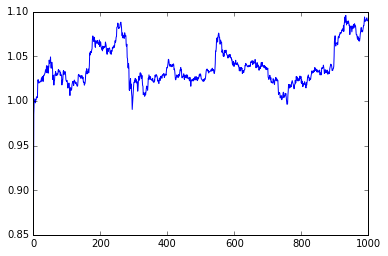

In [7]:
plt.plot(pred_close)

(-0.01, 0.01)

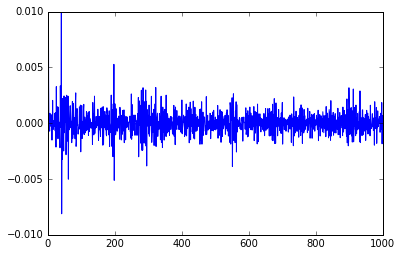

In [10]:
plt.plot(closes[:, 0] - pred_close)
plt.ylim(-0.01, 0.01)

In [12]:
kf = KalmanFilter(observation_matrices=np.expand_dims(closes[:, 1:], 1),
                      transition_covariance=np.eye(state_dim))

In [29]:
from copy import deepcopy
initial = 10


kf = KalmanFilter(observation_matrices=np.expand_dims(closes[:initial, 1:], 1),
                  transition_matrices=np.eye(state_dim))
means = []
covs = []
for i in range(initial, len(closes)):
    mean, cov = kf.filter(closes[:i, [0]])
    means.append(deepcopy(mean[-1]))
    covs.append(deepcopy(cov[-1]))
    print(closes[[i], 1:].shape)
    print(mean.shape, cov.shape)
    kf.filter_update(filtered_state_covariance=cov[-1],
                     filtered_state_mean=mean[-1],
                     observation_matrix=closes[[i], 1:])

(1, 6)
(10, 6) (10, 6, 6)


IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
kf.filter_update(observation_matrix=)

In [14]:
help(kf.filter)

Help on method filter in module pykalman.standard:

filter(X) method of pykalman.standard.KalmanFilter instance
    Apply the Kalman Filter
    
    Apply the Kalman Filter to estimate the hidden state at time :math:`t`
    for :math:`t = [0...n_{\text{timesteps}}-1]` given observations up to
    and including time `t`.  Observations are assumed to correspond to
    times :math:`[0...n_{\text{timesteps}}-1]`.  The output of this method
    corresponding to time :math:`n_{\text{timesteps}}-1` can be used in
    :func:`KalmanFilter.filter_update` for online updating.
    
    Parameters
    ----------
    X : [n_timesteps, n_dim_obs] array-like
        observations corresponding to times [0...n_timesteps-1].  If `X` is
        a masked array and any of `X[t]` is masked, then `X[t]` will be
        treated as a missing observation.
    
    Returns
    -------
    filtered_state_means : [n_timesteps, n_dim_state]
        mean of hidden state distributions for times [0...n_timesteps-1]
   

In [16]:
help(kf.filter_update)

Help on method filter_update in module pykalman.standard:

filter_update(filtered_state_mean, filtered_state_covariance, observation=None, transition_matrix=None, transition_offset=None, transition_covariance=None, observation_matrix=None, observation_offset=None, observation_covariance=None) method of pykalman.standard.KalmanFilter instance
    Update a Kalman Filter state estimate
    
    Perform a one-step update to estimate the state at time :math:`t+1`
    give an observation at time :math:`t+1` and the previous estimate for
    time :math:`t` given observations from times :math:`[0...t]`.  This
    method is useful if one wants to track an object with streaming
    observations.
    
    Parameters
    ----------
    filtered_state_mean : [n_dim_state] array
        mean estimate for state at time t given observations from times
        [1...t]
    filtered_state_covariance : [n_dim_state, n_dim_state] array
        covariance of estimate for state at time t given observations f